<a href="https://colab.research.google.com/github/PedroChumpitaz/A-Multilingual-Human-Agent-Interaction-System-for-Enhanced-International-Dining-Experiences/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.6 MB/s eta 0:00:00


=== VARIANTE A (Global Dynamic) ===
Wavelet: db2, Nivel: 3, RMSE: 2.0565
Wavelet: db2, Nivel: 4, RMSE: 1.6616
Wavelet: db2, Nivel: 5, RMSE: 1.5853
Wavelet: db3, Nivel: 3, RMSE: 1.9026
Wavelet: db3, Nivel: 4, RMSE: 1.5026
Wavelet: db3, Nivel: 5, RMSE: 1.4583
Wavelet: db4, Nivel: 3, RMSE: 2.0407
Wavelet: db4, Nivel: 4, RMSE: 1.4808
Wavelet: db4, Nivel: 5, RMSE: 1.3648
Wavelet: sym4, Nivel: 3, RMSE: 1.8978
Wavelet: sym4, Nivel: 4, RMSE: 1.4757
Wavelet: sym4, Nivel: 5, RMSE: 1.4134
Wavelet: coif1, Nivel: 3, RMSE: 1.8861
Wavelet: coif1, Nivel: 4, RMSE: 1.5507
Wavelet: coif1, Nivel: 5, RMSE: 1.5116
Wavelet: coif3, Nivel: 3, RMSE: 1.8933
Wavelet: coif3, Nivel: 4, RMSE: 1.4598
Wavelet: coif3, Nivel: 5, RMSE: 1.3862

Variante A: Wavelet=db4, Nivel=5
Umbrales óptimos: [ 3.54993036 11.06035939 16.83655423 15.74763102 16.83655423]
RMSE=1.3648, SNR=13.46 dB

=== VARIANTE B (Fixed Threshold - VisuShrink) ===
Umbrales fijos: [21.440156083388608, 21.440156083388608, 21.440156083388608, 21.440156083388

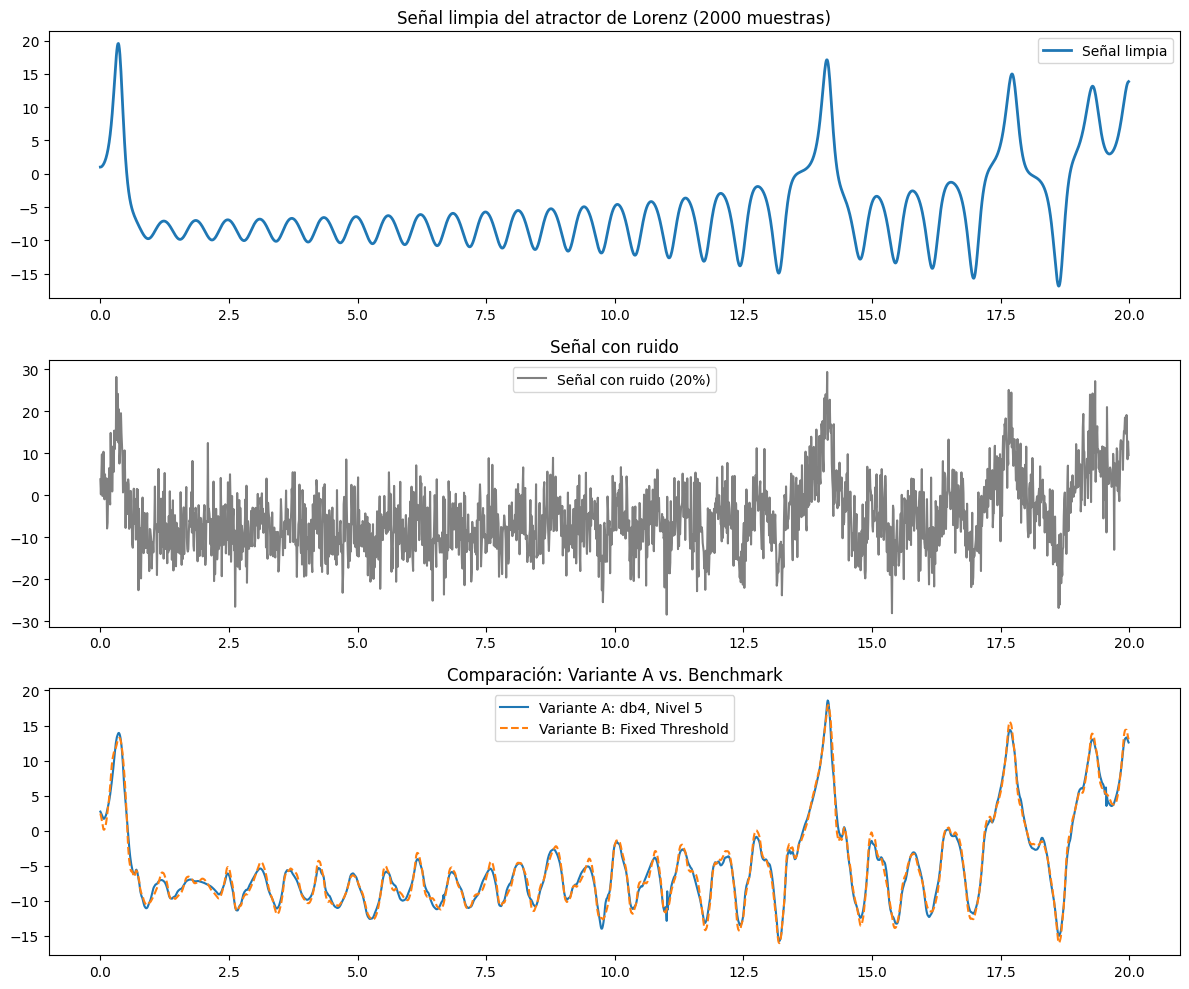

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution

# ============================
# 1. Generación del atractor de Lorenz
# ============================
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def generate_lorenz(T=50, dt=0.01, initial_state=(1, 1, 1)):
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)
    sol = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval, rtol=1e-9, atol=1e-9)
    return t_eval, sol.y

# ============================
# 2. Métricas y utilidades
# ============================
def mse(a, b):
    return np.mean((a - b) ** 2)

def rmse(a, b):
    return np.sqrt(mse(a, b))

def compute_snr(clean, filtered):
    noise = filtered - clean
    var_signal = np.var(clean)
    var_noise = np.var(noise)
    return 10 * np.log10(var_signal / var_noise) if var_noise != 0 else np.inf

# ============================
# 3. Filtrado por wavelet y umbralado (modo "soft")
# ============================
def wavelet_denoise(signal, thresholds, wavelet='db4', level=None):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    filtered_coeffs = [coeffs[0]]  # Coeficiente de aproximación sin modificar
    for i in range(1, len(coeffs)):
        thr = thresholds[i-1] if (i-1) < len(thresholds) else thresholds[-1]
        filtered_detail = pywt.threshold(coeffs[i], value=thr, mode='soft')
        filtered_coeffs.append(filtered_detail)
    filtered_signal = pywt.waverec(filtered_coeffs, wavelet)
    return filtered_signal[:len(signal)]

# ============================
# 4. Optimización de umbrales con Differential Evolution
# ============================
def optimize_thresholds(clean_signal, noisy_signal, wavelet='db4', level=4):
    def objective(thresholds):
        filtered = wavelet_denoise(noisy_signal, thresholds, wavelet=wavelet, level=level)
        return mse(clean_signal, filtered)

    # Acotamos los umbrales en [0, 2*std(noisy_signal)]
    bounds = [(0, np.std(noisy_signal)*2)] * level
    result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=50, disp=False)
    return result.x, result.fun

# ============================
# 5. VARIANTE A: Optimización dinámica global + selección adaptativa de wavelet y nivel
# ============================
def select_optimal_wavelet(clean_signal, noisy_signal, candidate_wavelets, candidate_levels):
    best_rmse_ = np.inf
    best_wavelet = None
    best_level = None
    best_thresholds = None
    best_filtered = None

    for wave in candidate_wavelets:
        for lev in candidate_levels:
            try:
                thresholds, _ = optimize_thresholds(clean_signal, noisy_signal, wavelet=wave, level=lev)
                filtered = wavelet_denoise(noisy_signal, thresholds, wavelet=wave, level=lev)
                current_rmse = rmse(clean_signal, filtered)
                print(f"Wavelet: {wave}, Nivel: {lev}, RMSE: {current_rmse:.4f}")
                if current_rmse < best_rmse_:
                    best_rmse_ = current_rmse
                    best_wavelet = wave
                    best_level = lev
                    best_thresholds = thresholds
                    best_filtered = filtered
            except Exception as e:
                print(f"Error con wavelet {wave} y nivel {lev}: {e}")
                continue

    return best_wavelet, best_level, best_thresholds, best_filtered, best_rmse_

# ============================
# 6. VARIANTE B: Benchmark - Umbral fijo (VisuShrink)
# ============================
def fixed_threshold_denoise(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Estimación robusta de sigma
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))  # Umbral universal (Donoho)
    thresholds = [uthresh] * level
    filtered_signal = wavelet_denoise(signal, thresholds, wavelet=wavelet, level=level)
    return filtered_signal, thresholds

# ============================
# 7. MAIN SCRIPT
# ============================
if __name__ == '__main__':
    # Generación de la señal limpia y la correspondiente con ruido
    t, lorenz_data = generate_lorenz(T=50, dt=0.01)
    x_clean = lorenz_data[0][:2000]
    t = t[:2000]

    noise_percentage = 0.90
    np.random.seed(42)
    noise = noise_percentage * np.std(x_clean) * np.random.randn(len(x_clean))
    x_noisy = x_clean + noise

    # --- VARIANTE A: Optimización dinámica global (selección adaptativa de wavelet y nivel)
    candidate_wavelets = ['db2', 'db3', 'db4', 'sym4', 'coif1', 'coif3']
    candidate_levels = [3, 4, 5]
    print("=== VARIANTE A (Global Dynamic) ===")
    best_wave, best_level, best_thresholds, x_filtered_A, _ = select_optimal_wavelet(
        x_clean, x_noisy, candidate_wavelets, candidate_levels)
    snr_A = compute_snr(x_clean, x_filtered_A)
    rmse_A = rmse(x_clean, x_filtered_A)
    print(f"\nVariante A: Wavelet={best_wave}, Nivel={best_level}")
    print("Umbrales óptimos:", best_thresholds)
    print(f"RMSE={rmse_A:.4f}, SNR={snr_A:.2f} dB")

    # --- VARIANTE B: Benchmark (Fixed Threshold - VisuShrink)
    print("\n=== VARIANTE B (Fixed Threshold - VisuShrink) ===")
    x_filtered_B, fixed_thresholds = fixed_threshold_denoise(x_noisy, wavelet='db4', level=4)
    snr_B = compute_snr(x_clean, x_filtered_B)
    rmse_B = rmse(x_clean, x_filtered_B)
    print("Umbrales fijos:", fixed_thresholds)
    print(f"RMSE={rmse_B:.4f}, SNR={snr_B:.2f} dB")

    # --- Gráficas comparativas
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plt.plot(t, x_clean, label='Señal limpia', linewidth=2)
    plt.title('Señal limpia del atractor de Lorenz (2000 muestras)')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(t, x_noisy, label='Señal con ruido (20%)', color='gray')
    plt.title('Señal con ruido')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(t, x_filtered_A, label=f'Variante A: {best_wave}, Nivel {best_level}', linewidth=1.5)
    plt.plot(t, x_filtered_B, label='Variante B: Fixed Threshold', linestyle='--', linewidth=1.5)
    plt.title('Comparación: Variante A vs. Benchmark')
    plt.legend()

    plt.tight_layout()
    plt.show()


Buscando la mejor combinación de wavelet y nivel (Global Dynamic)...
differential_evolution step 1: f(x)= 0.2581537099613429
differential_evolution step 2: f(x)= 0.2580035681199582
differential_evolution step 3: f(x)= 0.2577089834949718
differential_evolution step 4: f(x)= 0.257699663277865
differential_evolution step 5: f(x)= 0.2576962463448638
differential_evolution step 6: f(x)= 0.2576849905286349
differential_evolution step 7: f(x)= 0.2576849905286349
Polishing solution with 'L-BFGS-B'
Wavelet: db2, Nivel: 3, RMSE: 0.5076
differential_evolution step 1: f(x)= 0.25760270837260857
differential_evolution step 2: f(x)= 0.25501120858047777
differential_evolution step 3: f(x)= 0.25501120858047777
differential_evolution step 4: f(x)= 0.25501120858047777
differential_evolution step 5: f(x)= 0.2517688228445939
differential_evolution step 6: f(x)= 0.2517688228445939
differential_evolution step 7: f(x)= 0.2516770968959961
differential_evolution step 8: f(x)= 0.2516770968959961
differential_evo

/usr/local/lib/python3.11/dist-packages/pywt/_utils.py:26: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)



Variante G (PSO):
Umbrales PSO: [0.27852676 0.93239785 4.59937054 6.82571869 9.00757444]
Costo PSO: 0.1472745241780997
RMSE: 0.383763630608868
SNR: 24.42326946611447 dB
differential_evolution step 1: f(x)= 0.1771128620644571
differential_evolution step 2: f(x)= 0.1771128620644571
differential_evolution step 3: f(x)= 0.1771128620644571
differential_evolution step 4: f(x)= 0.1730879481012056
differential_evolution step 5: f(x)= 0.1730879481012056
differential_evolution step 6: f(x)= 0.1730879481012056
differential_evolution step 7: f(x)= 0.17250057814838135
differential_evolution step 8: f(x)= 0.17250057814838135
differential_evolution step 9: f(x)= 0.17228360544796112
differential_evolution step 10: f(x)= 0.17228360544796112
differential_evolution step 11: f(x)= 0.17185295911776766
differential_evolution step 12: f(x)= 0.17185295911776766
differential_evolution step 13: f(x)= 0.17185295911776766
differential_evolution step 14: f(x)= 0.17185295911776766
differential_evolution step 15: f

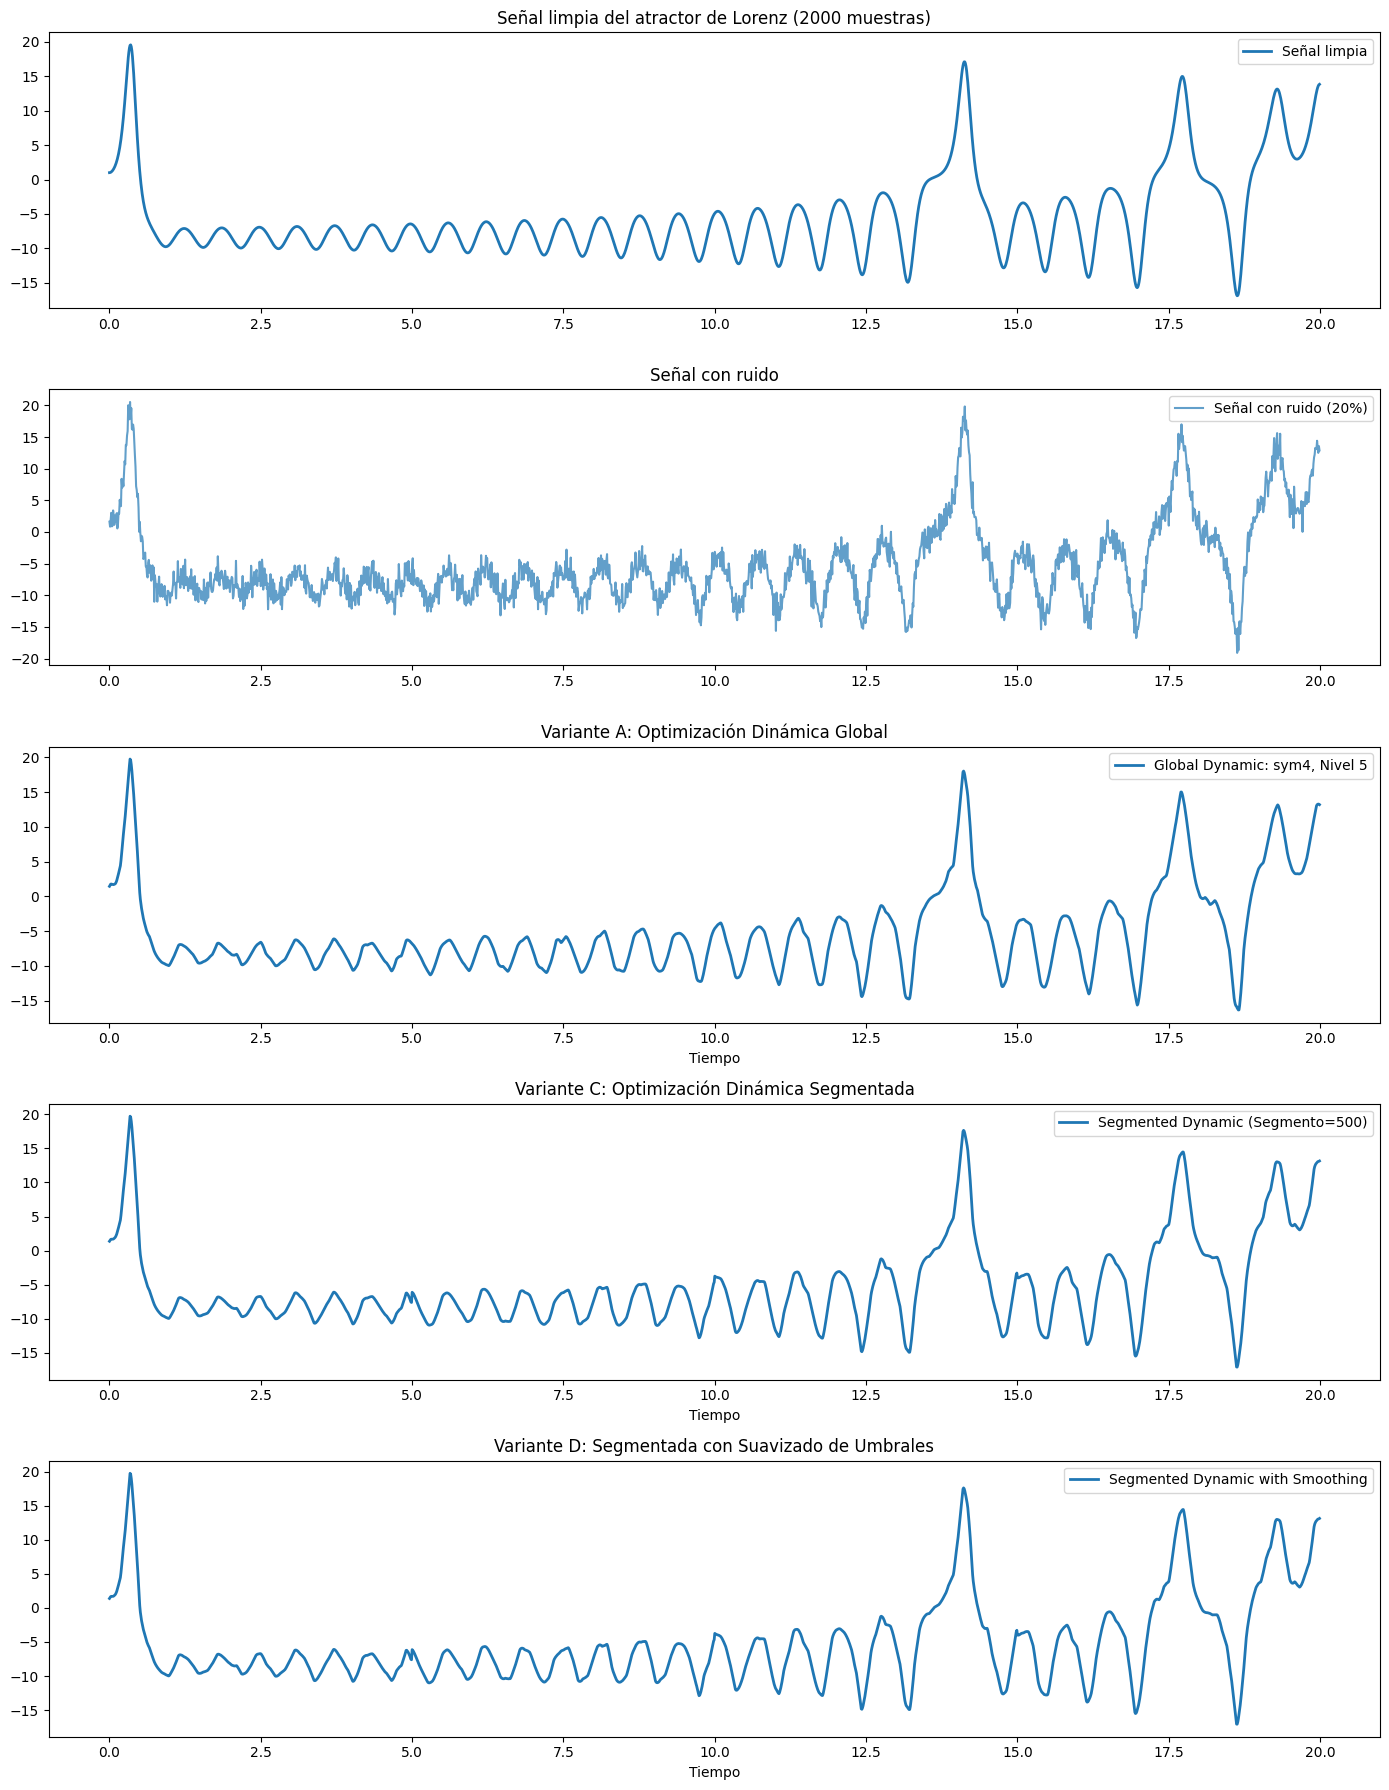

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution

# ============================
# 1. Generación del atractor de Lorenz
# ============================
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def generate_lorenz(T=50, dt=0.01, initial_state=(1, 1, 1)):
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)
    sol = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval, rtol=1e-9, atol=1e-9)
    return t_eval, sol.y

# ============================
# 2. Funciones básicas de filtrado y evaluación
# ============================
def wavelet_denoise(signal, thresholds, wavelet='db4', level=None):
    """
    Descompone la señal con wavedec y aplica umbralado suave (soft thresholding)
    a los coeficientes de detalle usando los umbrales especificados.
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    filtered_coeffs = [coeffs[0]]  # Aproximación sin modificar
    for i in range(1, len(coeffs)):
        thr = thresholds[i-1] if i-1 < len(thresholds) else thresholds[-1]
        filtered_detail = pywt.threshold(coeffs[i], value=thr, mode='soft')
        filtered_coeffs.append(filtered_detail)
    filtered_signal = pywt.waverec(filtered_coeffs, wavelet)
    return filtered_signal[:len(signal)]

def mse(a, b):
    return np.mean((a - b) ** 2)

def rmse(a, b):
    return np.sqrt(mse(a, b))

def compute_snr(clean, filtered):
    noise = filtered - clean
    var_signal = np.var(clean)
    var_noise = np.var(noise)
    return 10 * np.log10(var_signal / var_noise) if var_noise != 0 else np.inf

# ============================
# 3. Optimización dinámica de umbrales (Global Dynamic) - Variante A
# ============================
def optimize_thresholds(clean_signal, noisy_signal, wavelet='db4', level=4):
    def objective(thresholds):
        filtered = wavelet_denoise(noisy_signal, thresholds, wavelet=wavelet, level=level)
        return mse(clean_signal, filtered)
    bounds = [(0, np.std(noisy_signal)*2)] * level
    result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=50, disp=True)
    return result.x, result.fun

def select_optimal_wavelet(clean_signal, noisy_signal, candidate_wavelets, candidate_levels):
    best_rmse = np.inf
    best_wavelet = None
    best_level = None
    best_thresholds = None
    best_filtered = None
    for wave in candidate_wavelets:
        for lev in candidate_levels:
            try:
                thresholds, err = optimize_thresholds(clean_signal, noisy_signal, wavelet=wave, level=lev)
                filtered = wavelet_denoise(noisy_signal, thresholds, wavelet=wave, level=lev)
                current_rmse = rmse(clean_signal, filtered)
                print(f"Wavelet: {wave}, Nivel: {lev}, RMSE: {current_rmse:.4f}")
                if current_rmse < best_rmse:
                    best_rmse = current_rmse
                    best_wavelet = wave
                    best_level = lev
                    best_thresholds = thresholds
                    best_filtered = filtered
            except Exception as e:
                print(f"Error con wavelet {wave} y nivel {lev}: {e}")
                continue
    return best_wavelet, best_level, best_thresholds, best_filtered, best_rmse

# ============================
# 4. Benchmark: Umbral fijo (VisuShrink) - Variante B
# ============================
def fixed_threshold_denoise(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Desviación robusta
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))  # Umbral universal de Donoho
    thresholds = [uthresh] * level
    filtered_signal = wavelet_denoise(signal, thresholds, wavelet=wavelet, level=level)
    return filtered_signal, thresholds

# ============================
# 5. Variante C: Optimización dinámica segmentada (Dynamic per Segment)
# ============================
def segmented_optimize(clean_signal, noisy_signal, wavelet='db4', level=4, segment_length=500):
    n = len(clean_signal)
    segments_clean = [clean_signal[i:i+segment_length] for i in range(0, n, segment_length)]
    segments_noisy = [noisy_signal[i:i+segment_length] for i in range(0, n, segment_length)]
    thresholds_list = []
    filtered_segments = []
    for seg_clean, seg_noisy in zip(segments_clean, segments_noisy):
        thres, err = optimize_thresholds(seg_clean, seg_noisy, wavelet=wavelet, level=level)
        thresholds_list.append(thres)
        filtered_seg = wavelet_denoise(seg_noisy, thres, wavelet=wavelet, level=level)
        filtered_segments.append(filtered_seg)
    filtered_signal = np.concatenate(filtered_segments)
    return filtered_signal, thresholds_list

# ============================
# 6. Variante D: Segmentada con suavizado de umbrales (Combined Segment & Smoothing)
# ============================
def smooth_thresholds(thresholds_list):
    """
    Suaviza los umbrales calculados por segmento mediante media móvil.
    """
    thresholds_array = np.array(thresholds_list)  # Dim: (num_segmentos, level)
    smoothed = np.copy(thresholds_array)
    for j in range(thresholds_array.shape[1]):
        for i in range(1, thresholds_array.shape[0]-1):
            smoothed[i, j] = (thresholds_array[i-1, j] + thresholds_array[i, j] + thresholds_array[i+1, j]) / 3.0
    if thresholds_array.shape[0] > 1:
        smoothed[0, :] = (thresholds_array[0, :] + thresholds_array[1, :]) / 2.0
        smoothed[-1, :] = (thresholds_array[-2, :] + thresholds_array[-1, :]) / 2.0
    return smoothed

def segmented_optimize_smoothed(clean_signal, noisy_signal, wavelet='db4', level=4, segment_length=500):
    n = len(clean_signal)
    segments_clean = [clean_signal[i:i+segment_length] for i in range(0, n, segment_length)]
    segments_noisy = [noisy_signal[i:i+segment_length] for i in range(0, n, segment_length)]
    thresholds_list = []
    for seg_clean, seg_noisy in zip(segments_clean, segments_noisy):
        thres, err = optimize_thresholds(seg_clean, seg_noisy, wavelet=wavelet, level=level)
        thresholds_list.append(thres)
    smoothed_thresholds = smooth_thresholds(thresholds_list)
    filtered_segments = []
    for i, seg_noisy in enumerate(segments_noisy):
        filtered_seg = wavelet_denoise(seg_noisy, smoothed_thresholds[i], wavelet=wavelet, level=level)
        filtered_segments.append(filtered_seg)
    filtered_signal = np.concatenate(filtered_segments)
    return filtered_signal, smoothed_thresholds

# ============================
# NUEVAS ESTRATEGIAS ADICIONALES
# ============================

# Variante E: Optimización Multiobjetivo
def optimize_thresholds_multiobjective(clean_signal, noisy_signal, wavelet='db4', level=4, alpha=1.0, beta=0.01):
    """
    Función objetivo combinada: minimiza MSE y maximiza SNR.
    """
    def objective(thresholds):
        filtered = wavelet_denoise(noisy_signal, thresholds, wavelet=wavelet, level=level)
        mse_val = mse(clean_signal, filtered)
        snr_val = compute_snr(clean_signal, filtered)
        return mse_val - beta * snr_val  # Se busca minimizar este costo
    bounds = [(0, np.std(noisy_signal)*2)] * level
    result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=50, disp=True)
    return result.x, result.fun

# Variante F: Selección Extendida de Wavelet y Niveles
def select_optimal_wavelet_extended(clean_signal, noisy_signal, candidate_wavelets, candidate_levels):
    best_rmse = np.inf
    best_wavelet = None
    best_level = None
    best_thresholds = None
    best_filtered = None
    for wave in candidate_wavelets:
        for lev in candidate_levels:
            try:
                thresholds, err = optimize_thresholds(clean_signal, noisy_signal, wavelet=wave, level=lev)
                filtered = wavelet_denoise(noisy_signal, thresholds, wavelet=wave, level=lev)
                current_rmse = rmse(clean_signal, filtered)
                print(f"Extended - Wavelet: {wave}, Nivel: {lev}, RMSE: {current_rmse:.4f}")
                if current_rmse < best_rmse:
                    best_rmse = current_rmse
                    best_wavelet = wave
                    best_level = lev
                    best_thresholds = thresholds
                    best_filtered = filtered
            except Exception as e:
                print(f"Error Extended con wavelet {wave} y nivel {lev}: {e}")
                continue
    return best_wavelet, best_level, best_thresholds, best_filtered, best_rmse

# Variante G: Optimización de Umbrales con PSO
def pso_optimize_thresholds(clean_signal, noisy_signal, wavelet='db4', level=4, swarm_size=30, iterations=100, w=0.5, c1=1.0, c2=1.0):
    bounds = np.array([[0, np.std(noisy_signal)*2]] * level)
    dim = level
    positions = np.random.uniform(bounds[:,0], bounds[:,1], (swarm_size, dim))
    velocities = np.random.uniform(-1, 1, (swarm_size, dim))
    def objective(thresholds):
        filtered = wavelet_denoise(noisy_signal, thresholds, wavelet=wavelet, level=level)
        return mse(clean_signal, filtered)
    personal_best = positions.copy()
    personal_best_scores = np.array([objective(pos) for pos in positions])
    global_best_index = np.argmin(personal_best_scores)
    global_best = personal_best[global_best_index].copy()
    global_best_score = personal_best_scores[global_best_index]
    for it in range(iterations):
        for i in range(swarm_size):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = w*velocities[i] + c1*r1*(personal_best[i]-positions[i]) + c2*r2*(global_best-positions[i])
            positions[i] = positions[i] + velocities[i]
            positions[i] = np.clip(positions[i], bounds[:,0], bounds[:,1])
            score = objective(positions[i])
            if score < personal_best_scores[i]:
                personal_best[i] = positions[i].copy()
                personal_best_scores[i] = score
                if score < global_best_score:
                    global_best = positions[i].copy()
                    global_best_score = score
        # Opcional: imprimir estado de la iteración
        # print(f"PSO iteración {it}: mejor score = {global_best_score}")
    return global_best, global_best_score

# Variante H: Umbralado Fuzzy
def fuzzy_threshold(x, threshold, delta=0.1):
    """
    Función de umbralado fuzzy usando tanh para suavizar la transición.
    """
    return x * 0.5*(1 + np.tanh((np.abs(x) - threshold)/delta))

def wavelet_denoise_fuzzy(signal, thresholds, wavelet='db4', level=None, delta=0.1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    filtered_coeffs = [coeffs[0]]  # Aproximación sin modificar
    for i in range(1, len(coeffs)):
        thr = thresholds[i-1] if i-1 < len(thresholds) else thresholds[-1]
        fuzzy_filtered = np.array([fuzzy_threshold(val, thr, delta) for val in coeffs[i]])
        filtered_coeffs.append(fuzzy_filtered)
    filtered_signal = pywt.waverec(filtered_coeffs, wavelet)
    return filtered_signal[:len(signal)]

def optimize_thresholds_fuzzy(clean_signal, noisy_signal, wavelet='db4', level=4, delta=0.1):
    def objective(thresholds):
        filtered = wavelet_denoise_fuzzy(noisy_signal, thresholds, wavelet=wavelet, level=level, delta=delta)
        return mse(clean_signal, filtered)
    bounds = [(0, np.std(noisy_signal)*2)] * level
    result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=50, disp=True)
    return result.x, result.fun

# Variante I: Optimización Segmentada Iterativa
def segmented_optimize_iterative(clean_signal, noisy_signal, wavelet='db4', level=4, segment_length=500, iterations=2):
    n = len(clean_signal)
    segments_clean = [clean_signal[i:i+segment_length] for i in range(0, n, segment_length)]
    segments_noisy = [noisy_signal[i:i+segment_length] for i in range(0, n, segment_length)]
    thresholds_list = []
    filtered_segments = []
    for seg_clean, seg_noisy in zip(segments_clean, segments_noisy):
        # Optimización inicial
        thres, err = optimize_thresholds(seg_clean, seg_noisy, wavelet=wavelet, level=level)
        # Iteración para refinar
        for it in range(iterations):
            filtered_seg = wavelet_denoise(seg_noisy, thres, wavelet=wavelet, level=level)
            thres, err = optimize_thresholds(seg_clean, seg_noisy, wavelet=wavelet, level=level)
        thresholds_list.append(thres)
        filtered_seg = wavelet_denoise(seg_noisy, thres, wavelet=wavelet, level=level)
        filtered_segments.append(filtered_seg)
    filtered_signal = np.concatenate(filtered_segments)
    return filtered_signal, thresholds_list

# ============================
# 7. Script principal para la comparación de variantes
# ============================
if __name__ == '__main__':
    # Generar la señal limpia del atractor de Lorenz (componente x)
    t, lorenz_data = generate_lorenz(T=50, dt=0.01)
    x_clean = lorenz_data[0][:2000]
    t = t[:2000]

    # Inyectar ruido gaussiano blanco: Nivel de ruido del 20%
    noise_percentage = 0.20
    np.random.seed(42)
    noise = noise_percentage * np.std(x_clean) * np.random.randn(len(x_clean))
    x_noisy = x_clean + noise

    # -------------------------------
    # Variante A: Optimización dinámica global con selección adaptativa de base y nivel
    candidate_wavelets = ['db2', 'db3', 'db4', 'sym4', 'coif1', 'coif3']
    candidate_levels = [3, 4, 5]
    print("Buscando la mejor combinación de wavelet y nivel (Global Dynamic)...")
    best_wave, best_level, best_thresholds, x_filtered_dynamic, best_rmse = select_optimal_wavelet(
        x_clean, x_noisy, candidate_wavelets, candidate_levels)
    snr_dynamic = compute_snr(x_clean, x_filtered_dynamic)
    rmse_dynamic = rmse(x_clean, x_filtered_dynamic)
    print(f"\nVariante A (Global Dynamic): Wavelet = {best_wave}, Nivel = {best_level}")
    print("Umbrales óptimos:", best_thresholds)
    print("RMSE:", rmse_dynamic)
    print("SNR:", snr_dynamic, "dB")

    # -------------------------------
    # Variante B: Benchmark - Umbral fijo (VisuShrink) con base y nivel fijos (db4, nivel 4)
    wavelet_name = 'db4'
    decomp_level = 4
    x_filtered_fixed, fixed_thresholds = fixed_threshold_denoise(x_noisy, wavelet=wavelet_name, level=decomp_level)
    snr_fixed = compute_snr(x_clean, x_filtered_fixed)
    rmse_fixed = rmse(x_clean, x_filtered_fixed)
    print("\nVariante B (Fixed Threshold - VisuShrink):")
    print("Umbrales fijos:", fixed_thresholds)
    print("RMSE:", rmse_fixed)
    print("SNR:", snr_fixed, "dB")

    # -------------------------------
    # Variante C: Optimización dinámica segmentada (Dynamic per Segment)
    segment_length = 500
    x_filtered_segmented, thresholds_segments = segmented_optimize(x_clean, x_noisy, wavelet=best_wave, level=best_level, segment_length=segment_length)
    snr_segmented = compute_snr(x_clean, x_filtered_segmented)
    rmse_segmented = rmse(x_clean, x_filtered_segmented)
    print("\nVariante C (Segmented Dynamic):")
    print("RMSE:", rmse_segmented)
    print("SNR:", snr_segmented, "dB")

    # -------------------------------
    # Variante D: Segmentada con suavizado de umbrales (Combined Segment & Smoothing)
    x_filtered_seg_smoothed, smoothed_thresholds = segmented_optimize_smoothed(x_clean, x_noisy, wavelet=best_wave, level=best_level, segment_length=segment_length)
    snr_seg_smoothed = compute_snr(x_clean, x_filtered_seg_smoothed)
    rmse_seg_smoothed = rmse(x_clean, x_filtered_seg_smoothed)
    print("\nVariante D (Segmented Dynamic with Smoothing):")
    print("RMSE:", rmse_seg_smoothed)
    print("SNR:", snr_seg_smoothed, "dB")

    # -------------------------------
    # Variante E: Optimización Multiobjetivo
    thresholds_multi, cost_multi = optimize_thresholds_multiobjective(x_clean, x_noisy, wavelet=best_wave, level=best_level, alpha=1.0, beta=0.01)
    x_filtered_multi = wavelet_denoise(x_noisy, thresholds_multi, wavelet=best_wave, level=best_level)
    snr_multi = compute_snr(x_clean, x_filtered_multi)
    rmse_multi = rmse(x_clean, x_filtered_multi)
    print("\nVariante E (Multiobjetivo):")
    print("Umbrales:", thresholds_multi)
    print("Costo:", cost_multi)
    print("RMSE:", rmse_multi)
    print("SNR:", snr_multi, "dB")

    # -------------------------------
    # Variante F: Selección Extendida de Wavelet y Niveles
    candidate_wavelets_ext = ['db2', 'db3', 'db4', 'sym4', 'coif1', 'coif3', 'morl', 'cmor']
    candidate_levels_ext = [2, 3, 4, 5, 6]
    best_wave_ext, best_level_ext, best_thresholds_ext, x_filtered_ext, best_rmse_ext = select_optimal_wavelet_extended(
        x_clean, x_noisy, candidate_wavelets_ext, candidate_levels_ext)
    snr_ext = compute_snr(x_clean, x_filtered_ext)
    rmse_ext = rmse(x_clean, x_filtered_ext)
    print("\nVariante F (Selección Extendida):")
    print(f"Wavelet = {best_wave_ext}, Nivel = {best_level_ext}")
    print("Umbrales óptimos:", best_thresholds_ext)
    print("RMSE:", rmse_ext)
    print("SNR:", snr_ext, "dB")

    # -------------------------------
    # Variante G: Optimización con PSO
    thresholds_pso, cost_pso = pso_optimize_thresholds(x_clean, x_noisy, wavelet=best_wave, level=best_level, swarm_size=30, iterations=100)
    x_filtered_pso = wavelet_denoise(x_noisy, thresholds_pso, wavelet=best_wave, level=best_level)
    snr_pso = compute_snr(x_clean, x_filtered_pso)
    rmse_pso = rmse(x_clean, x_filtered_pso)
    print("\nVariante G (PSO):")
    print("Umbrales PSO:", thresholds_pso)
    print("Costo PSO:", cost_pso)
    print("RMSE:", rmse_pso)
    print("SNR:", snr_pso, "dB")

    # -------------------------------
    # Variante H: Umbralado Fuzzy
    thresholds_fuzzy, cost_fuzzy = optimize_thresholds_fuzzy(x_clean, x_noisy, wavelet=best_wave, level=best_level, delta=0.1)
    x_filtered_fuzzy = wavelet_denoise_fuzzy(x_noisy, thresholds_fuzzy, wavelet=best_wave, level=best_level, delta=0.1)
    snr_fuzzy = compute_snr(x_clean, x_filtered_fuzzy)
    rmse_fuzzy = rmse(x_clean, x_filtered_fuzzy)
    print("\nVariante H (Fuzzy Thresholding):")
    print("Umbrales fuzzy:", thresholds_fuzzy)
    print("Costo fuzzy:", cost_fuzzy)
    print("RMSE:", rmse_fuzzy)
    print("SNR:", snr_fuzzy, "dB")

    # -------------------------------
    # Variante I: Optimización Segmentada Iterativa
    x_filtered_iter, thresholds_iter = segmented_optimize_iterative(x_clean, x_noisy, wavelet=best_wave, level=best_level, segment_length=segment_length, iterations=2)
    snr_iter = compute_snr(x_clean, x_filtered_iter)
    rmse_iter = rmse(x_clean, x_filtered_iter)
    print("\nVariante I (Segmented Iterative):")
    print("RMSE:", rmse_iter)
    print("SNR:", snr_iter, "dB")

    # -------------------------------
    # Mostrar métricas comparativas
    print("\n--- Métricas Comparativas ---")
    print(f"Variante A (Global Dynamic): SNR = {snr_dynamic:.2f} dB, RMSE = {rmse_dynamic:.4f}")
    print(f"Variante B (Fixed Threshold - VisuShrink): SNR = {snr_fixed:.2f} dB, RMSE = {rmse_fixed:.4f}")
    print(f"Variante C (Segmented Dynamic): SNR = {snr_segmented:.2f} dB, RMSE = {rmse_segmented:.4f}")
    print(f"Variante D (Segmented with Smoothing): SNR = {snr_seg_smoothed:.2f} dB, RMSE = {rmse_seg_smoothed:.4f}")
    print(f"Variante E (Multiobjetivo): SNR = {snr_multi:.2f} dB, RMSE = {rmse_multi:.4f}")
    print(f"Variante F (Selección Extendida): SNR = {snr_ext:.2f} dB, RMSE = {rmse_ext:.4f}")
    print(f"Variante G (PSO): SNR = {snr_pso:.2f} dB, RMSE = {rmse_pso:.4f}")
    print(f"Variante H (Fuzzy): SNR = {snr_fuzzy:.2f} dB, RMSE = {rmse_fuzzy:.4f}")
    print(f"Variante I (Segmented Iterative): SNR = {snr_iter:.2f} dB, RMSE = {rmse_iter:.4f}")

    # -------------------------------
    # Graficar algunos resultados (se mantienen A, C y D para visualización)
    plt.figure(figsize=(14, 18))

    plt.subplot(5, 1, 1)
    plt.plot(t, x_clean, label='Señal limpia', linewidth=2)
    plt.title('Señal limpia del atractor de Lorenz (2000 muestras)')
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(t, x_noisy, label='Señal con ruido (20%)', alpha=0.7)
    plt.title('Señal con ruido')
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(t, x_filtered_dynamic, label=f'Global Dynamic: {best_wave}, Nivel {best_level}', linewidth=2)
    plt.title('Variante A: Optimización Dinámica Global')
    plt.xlabel('Tiempo')
    plt.legend()

    plt.subplot(5, 1, 4)
    plt.plot(t, x_filtered_segmented, label=f'Segmented Dynamic (Segmento={segment_length})', linewidth=2)
    plt.title('Variante C: Optimización Dinámica Segmentada')
    plt.xlabel('Tiempo')
    plt.legend()

    plt.subplot(5, 1, 5)
    plt.plot(t, x_filtered_seg_smoothed, label='Segmented Dynamic with Smoothing', linewidth=2)
    plt.title('Variante D: Segmentada con Suavizado de Umbrales')
    plt.xlabel('Tiempo')
    plt.legend()

    plt.tight_layout()
    plt.show()
